# Optimally Creating and Assigning Work Orders Based on Routes

A pretty common task for organizations is optimally distributing work orders. Suppose our organization needs to perform restaurant/brewery inspections in the Greater Portland, Maine area. Let's assume that there are around 25 breweries that need to be inspected and that there are 5 workers that are available to do the inspections. As the supervisor of these workers I'm going to develop a Python Script (well, Jupyter Notebook in this case) that will optimally create distinct routes for my workers, create assignments at the hydrant locations, and then assign the assignment to the correct worker.

## Scenario 1: Creating and Assigning Assignments From Planned Routes
In this scenario we are going to generate one route per worker. Each route will have up to 5 breweries (stored in an existing Feature Layer) that must be visisted and inspected. For each of the genenerated routes, we'll see which breweries need to be inspected and create assignments for them. We'll also assign the assignments to the worker that will be driving that route.

### Connecting to the Organization and Workforce project

First let's connect to our GIS and fetch the Brewery Inspection Workforce Project.

In [1]:
import pandas as pd
import arcgis
from arcgis.gis import GIS
from arcgis.apps import workforce
pd.options.display.max_columns = None

gis = GIS("https://arcgis.com", "workforce_scripts")
project = workforce.Project(gis.content.search("type:'Workforce Project' Brewery Inspections")[0])

Enter password: ········


### Viewing the breweries that need to be inspected

Now let's fetch the Breweries Feature Layer that our organization maintains.

<Item title:"Maine Breweries" type:Feature Layer Collection owner:workforce_scripts>
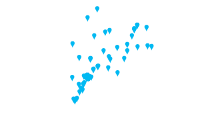

In [2]:
breweries_item = gis.content.search("type:'Feature Service' owner:workforce_scripts Maine Breweries")[0]
breweries_item

Let's query to find all of the breweries in the layer. You can see some of the detailed information in the dataframe below.

In [3]:
breweries_layer = breweries_item.layers[0]
breweries_filter = "location in ('Portland','South Portland','Gorham','Biddeford','Scarborough', 'Topsham','Freeport')"
breweries_df = breweries_layer.query(where=breweries_filter,out_fields="objectid,name,location,url", as_df=True)
breweries_df

,SHAPE,location,name,objectid,url
0,"{""x"": -7842761.363299999, ""y"": 5387249.8882, ""...",Biddeford,Banded Horn Brewing Company,1,http://www.bandedhorn.com/
1,"{""x"": -7827788.769099999, ""y"": 5419613.4034999...",Portland,Allagash Brewing Company,2,http://www.allagash.com
2,"{""x"": -7827976.476500001, ""y"": 5419540.3176999...",Portland,Austin Street Brewery,9,http://www.austinstreetbrewery.com/
3,"{""x"": -7827992.3013, ""y"": 5419591.972199999, ""...",Portland,Bissell Brothers,10,http://www.bissellbrothers.com/
4,"{""x"": -7820870.4265, ""y"": 5414061.9846, ""spati...",Portland,Bunker Brewing Co.,11,http://bunkerbrewingco.com/
5,"{""x"": -7824456.296700001, ""y"": 5408829.7722999...",Portland,Fore River Brewing Company,12,http://www.foreriverbrewing.com/
6,"{""x"": -7827960.353, ""y"": 5419581.223200001, ""s...",Portland,Foundation Brewing Company,13,http://foundationbrew.com/
7,"{""x"": -7827381.4022, ""y"": 5420339.920400001, ""...",Portland,Geary Brewing Co.,14,http://www.gearybrewing.com/
8,"{""x"": -7820579.2434, ""y"": 5412405.279299997, ""...",Portland,Gritty's,15,http://grittys.com/
9,"{""x"": -7820871.3807, ""y"": 5414439.781300001, ""...",Portland,Gruit,16,http://fermentory.com/


### Creating optimal routes for each worker

Now that we know what we're working with, let's use the [Plan Routes](https://doc.arcgis.com/en/arcgis-online/analyze/plan-routes.htm) tool to generate the most optimal routes for each of the workers. First we need to define where the workers will start their routes. Each worker will begin from the main office located at 100 Commercial Street, Portland Maine. We'll use the [geocoding module](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.geocoding.html#geocode) to get an exact location for this address.

In [4]:
from arcgis.geocoding import geocode
start_location = geocode("100 Commercial Street, Portland, ME", out_sr={"wkid": 102100})[0]["location"]
start_location

{'x': -7820327.020961544, 'y': 5412458.446412361}

Next, we need to convert this location into an in-memory feature layer that we can submit to the Plan Routes tools. First, we'll add the spatial reference to the location; this will help us later on when we need to create a feature collection.

In [5]:
start_location["spatialReference"] = {"wkid": 102100}

Then we'll create a [Feature](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#feature) from this location and supply a "Name" field.

In [6]:
feature = arcgis.features.Feature(
    attributes={
        "ObjectID": 1,
        "Name": "Office"
    },
    geometry=start_location
)

Next, we'll create a [Feature Set](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#featureset) from the feature. Then we'll create a [Feature Collection](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#featurecollection) from the Feature Set. Finally, we'll format the layer so that it conforms to the expected input format defined [here](https://doc.arcgis.com/en/arcgis-online/analyze/plan-routes.htm).

In [7]:
feature_set = arcgis.features.FeatureSet([feature])
feature_collection = arcgis.features.FeatureCollection.from_featureset(feature_set)
start_layer = {"layerDefinition": feature_collection.properties["layers"][0]["layerDefinition"], "featureSet": feature_set.value}

Then we'll run the [Plan Routes](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.analysis.html#plan-routes) tool using the breweries layer as list of stops to route to. We'll set the number of routes equal to the number of workers. We'll also set the start time and start location as well as few other parameters.

In [8]:
from datetime import datetime
workers = project.workers.search()
breweries_layer.filter = breweries_filter
results = arcgis.features.analysis.plan_routes(breweries_layer, # Feature Layer of Stops
                                    len(workers),               # Number of routes to generate
                                    5,                          # Maximum stops per route
                                    datetime.now(),             # Start time of route
                                    start_layer,                # The dictionary we created to represent the start location
                                    stop_service_time=60,       # How much time in minutes to spend at each stop
                                    max_route_time=480,         # The maximum time for the worker to complete the route
                                    )
results

Input field [OID] was not mapped to a field in the network analysis class "Orders".
Input field [OID] was not mapped to a field in the network analysis class "Depots".


{'routes_layer': <FeatureCollection>,
 'assigned_stops_layer': <FeatureCollection>,
 'unassigned_stops_layer': <FeatureCollection>}

As shown above, the output of the Plan Routes tool is a dictionary of 3 Feature Collections. One for the generated routes, one for the stops that were assigned to a route, and one for the stops that were not assigned a route. Let's see what information is provided in a route.

In [9]:
routes = results['routes_layer'].query().sdf
routes

,EndTime,EndTimeUTC,ObjectID,RouteLayerItemID,RouteLayerItemURL,RouteName,SHAPE,StartTime,StartTimeUTC,StopCount,TotalStopServiceTime,TotalTime,TotalTravelTime,Total_Kilometers,Total_Miles
0,2018-12-08 00:19:19.963000059,2018-12-08 05:19:19.963000059,1,None,None,Office - Route1,"{""paths"": [[[-7820328.7026, 5412461.669], [-78...",2018-12-07 20:08:59,2018-12-08 01:08:59,3,180,250.349376,70.349376,90.060515,55.961149
1,2018-12-08 02:43:04.957999945,2018-12-08 07:43:04.957999945,2,None,None,Office - Route2,"{""paths"": [[[-7820328.7026, 5412461.669], [-78...",2018-12-07 20:08:59,2018-12-08 01:08:59,5,300,394.099301,94.099301,82.479989,51.250816
2,2018-12-08 01:46:01.910000086,2018-12-08 06:46:01.910000086,3,None,None,Office - Route3,"{""paths"": [[[-7820328.7026, 5412461.669], [-78...",2018-12-07 20:08:59,2018-12-08 01:08:59,5,300,337.048507,37.048507,20.804615,12.927421
3,2018-12-08 01:23:09.861000061,2018-12-08 06:23:09.861000061,4,None,None,Office - Route4,"{""paths"": [[[-7820328.7026, 5412461.669], [-78...",2018-12-07 20:08:59,2018-12-08 01:08:59,5,300,314.181023,14.181023,4.036221,2.507998
4,2018-12-08 00:28:23.733000040,2018-12-08 05:28:23.733000040,5,None,None,Office - Route5,"{""paths"": [[[-7820328.7026, 5412461.669], [-78...",2018-12-07 20:08:59,2018-12-08 01:08:59,4,240,259.412217,19.412217,12.202277,7.582163


You can see that each route has a name, total time, and total distance among other things. Let's see what information is provided in an assigned stop.

In [10]:
stops = results['assigned_stops_layer'].query().sdf
stops

,ArriveTime,ArriveTimeUTC,CreationDate,Creator,DepartTime,DepartTimeUTC,EditDate,Editor,FromPrevDistance,FromPrevDistanceKilometers,FromPrevTravelTime,GlobalID_2,OBJECTID,OID,RouteName,SHAPE,Sequence,ServiceTime,StopType,address,contactnum,dining,district,globalid,location,name,snacks,tastingroo,tour,uniqueid,url
0,2018-12-07 20:08:59.000000000,2018-12-08 01:08:59.000000000,NaT,None,2018-12-07 20:08:59.000000000,2018-12-08 01:08:59.000000000,NaT,None,0.000000,0.000000,0.000000,None,1,1,Office - Route1,"{""x"": -7820327.020924952, ""y"": 5412458.4464164...",1,0,Route start,None,None,NaN,NaN,None,None,None,NaN,NaN,NaN,None,None
1,2018-12-07 20:29:03.292000055,2018-12-08 01:29:03.292000055,2018-12-03 14:43:15,nitroadmin,2018-12-07 21:29:03.292000055,2018-12-08 02:29:03.292000055,2018-12-03 14:43:15,nitroadmin,16.001138,25.751271,20.071527,{8382834F-E2B0-4023-8573-67A475DDB036},2,2,Office - Route1,"{""x"": -7805915.979097417, ""y"": 5440666.2457726...",2,60,Stop,None,207-221-5711,0.0,2.0,c8991bf0-aeba-449f-90ce-cef7e5c87fdf,Freeport,Maine Beer Company,1.0,1.0,0.0,86a5a077-a0ce-41c7-9ab4-5d023f2142fd,http://www.mainebeercompany.com/
2,2018-12-07 21:30:36.707999945,2018-12-08 02:30:36.707999945,2018-12-03 14:43:15,nitroadmin,2018-12-07 22:30:36.707999945,2018-12-08 03:30:36.707999945,2018-12-03 14:43:15,nitroadmin,0.691563,1.112960,1.556941,{A129CFC9-26CB-4A00-B3FB-60945898DD01},3,3,Office - Route1,"{""x"": -7804916.088462027, ""y"": 5441788.6862878...",3,60,Stop,None,207-865-4321,1.0,2.0,0775244f-d32c-434c-91cd-40abf1b2c77d,Freeport,Gritty's,1.0,1.0,1.0,da76f11c-e366-4634-9e42-04466f0573f4,http://grittys.com
3,2018-12-07 22:46:35.957999945,2018-12-08 03:46:35.957999945,2018-12-03 14:43:15,nitroadmin,2018-12-07 23:46:35.957999945,2018-12-08 04:46:35.957999945,2018-12-03 14:43:15,nitroadmin,12.613527,20.299454,15.987498,{B292916D-256B-49DF-B5A2-1602881C6D0F},4,4,Office - Route1,"{""x"": -7788449.072572963, ""y"": 5453299.6818928...",4,60,Stop,None,207-725-0162,1.0,5.0,e8af7140-8335-4132-a97d-c1d8d5fdf97b,Topsham,Sea Dog Brewing Company,0.0,0.0,0.0,b1ed0cc8-3a60-4c2d-8285-7d8d768ff3d8,http://www.seadogbrewing.com/topsham.php
4,2018-12-08 00:19:19.963000059,2018-12-08 05:19:19.963000059,NaT,None,2018-12-08 00:19:19.963000059,2018-12-08 05:19:19.963000059,NaT,None,26.654921,42.896830,32.733410,None,5,5,Office - Route1,"{""x"": -7820327.020924952, ""y"": 5412458.4464164...",5,0,Route end,None,None,NaN,NaN,None,None,None,NaN,NaN,NaN,None,None
5,2018-12-07 20:08:59.000000000,2018-12-08 01:08:59.000000000,NaT,None,2018-12-07 20:08:59.000000000,2018-12-08 01:08:59.000000000,NaT,None,0.000000,0.000000,0.000000,None,6,6,Office - Route2,"{""x"": -7820327.020924952, ""y"": 5412458.4464164...",1,0,Route start,None,None,NaN,NaN,None,None,None,NaN,NaN,NaN,None,None
6,2018-12-07 20:19:30.134000063,2018-12-08 01:19:30.134000063,2018-12-03 14:43:15,nitroadmin,2018-12-07 21:19:30.134000063,2018-12-08 02:19:30.134000063,2018-12-03 14:43:15,nitroadmin,4.223296,6.796720,10.518898,{4B5E952C-227C-4FF2-B081-634E2C4FC1A2},7,7,Office - Route2,"{""x"": -7827882.4981811065, ""y"": 5409156.281760...",2,60,Stop,None,207-871-7000,1.0,2.0,305bb3c2-a266-4e60-9e68-5d511b56758d,South Portland,Sea Dog Brewing Co.,0.0,0.0,0.0,3a765bc5-c14d-474a-9f76-16a4d9b366a0,http://www.seadogbrewing.com/
7,2018-12-07 21:34:32.318000078,2018-12-08 02:34:32.318000078,2018-12-03 14:43:15,nitroadmin,2018-12-07 22:34:32.318000078,2018-12-08 03:34:32.318000078,2018-12-03 14:43:15,nitroadmin,7.166526,11.533377,15.036395,{F580A49B-37A5-4889-BC84-16095EBC30DA},8,8,Office - Route2,"{""x"": -7836534.278656779, ""y"": 5416001.4026331...",3,60,Stop,None,207-856-2537,0.0,2.0,bc2b1776-ad57-4119-bb60-7738d57b0cd5,Gorham,Sebago Brewing Company,0.0,1.0,1.0,108d3b7d-4dde-4f1f-a561-36c96f2dfe94,http://sebagobrewing.com/
8,2018-12-07 22:42:53.308000088,2018-12-08 03:42:53.308000088,2018-12-03 14:43:15,nitroadmin,2018-12-07 23:42:53.308000088,2018-12-08 04:42:53.308000088,2018-12-03 14:43:15,nitroadmin,3.

You can see each row in the above table contains the attributes of each Brewery along with information about which route it is on. You'll also notice that there are several additional stops not related to a brewery. These are the starting and ending locations of each route.

### Create Assignment and Assign To Worker
For each route that was generated we will select a random worker to complete that route. Then we'll find the breweries that were assigned to that route and create an Inspection Assignment for each one. Notice that when the assignment is created we are also assigning it to a worker.

An important thing to note is that we are setting the due date of the assignment to the departure date of the stop. This means that a mobile worker will be able to sort their "To Do" list by due date and see the assignments in the correct order (according to the route).

In [11]:
import random

assignments_to_add = []
for _, row in routes.iterrows():
    worker = random.choice(workers)
    workers.remove(worker)
    route_stops = stops.loc[(stops['RouteName'] == row["RouteName"]) & stops['globalid'].notnull()]
    for _, stop in route_stops.iterrows():
        assignments_to_add.append(workforce.Assignment(
            project,
            assignment_type="Inspection",
            location=stop["name"],
            status="assigned",
            worker=worker,
            assigned_date=datetime.now(),
            due_date=stop["DepartTime"],
            geometry=stop["SHAPE"]
        ))
assignments = project.assignments.batch_add(assignments_to_add)

Let's see what this looks like in a map where the color of the assignment and route corresponds to the assigned worker. You can see that, in general, the colors are grouped together which is what we would expect. For example, the purple assignments are all placed on route that travels from Portland to Brunswick.

![image](images/routes_and_assignments.png)

## Scenario 2: Assigning Existing Assignments Based on Planned Routes
In this scenario we already have assignments added to a Workforce Project. We are going to do something very similar to what we previously did, but this time instead of creating new assignments, we're going to assign workers to existing assignments. To accomplish this we'll generate one route per worker. Each route will have up to 5 assignments that must completed. For all of the assignments along each generated route, we'll assign a worker.

### Connecting to the Organization and Workforce project
First let's connect to our GIS and fetch the Restaurant Inspections Workforce Project.

In [12]:
import arcgis
from arcgis.gis import GIS
from arcgis.apps import workforce

gis = GIS("https://arcgis.com", "workforce_scripts")
project = workforce.Project(gis.content.search("type:'Workforce Project' Restaurant Inspections")[0])

Enter password: ········


### Run Plan Routes tool using the assignments layer as the input
Each worker will begin from the main office located at 100 Commercial Street, Portland Maine. We'll use the [geocoding module](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.geocoding.html#geocode) to get an exact location for this address.

In [13]:
from arcgis.geocoding import geocode
start_location = geocode("100 Commercial Street, Portland, ME", out_sr={"wkid": 102100})[0]["location"]
start_location

{'x': -7820327.020961544, 'y': 5412458.446412361}

Then we'll create a new [Feature](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#feature) for this location.

In [14]:
start_location["spatialReference"] = {"wkid": 102100}
start_location

feature = arcgis.features.Feature(
    attributes={
        "ObjectID": 1,
        "Name": "Office"
    },
    geometry=start_location
)

Next, we'll create the layer that represents where the route should start.

In [15]:
feature_set = arcgis.features.FeatureSet([feature])
feature_collection = arcgis.features.FeatureCollection.from_featureset(feature_set)
start_layer = {"layerDefinition": feature_collection.properties["layers"][0]["layerDefinition"], "featureSet": feature_set.value}

Next, we'll execute the [Plan Routes](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.analysis.html#plan-routes) tool using all unassigned assignments as the input layer. We'll set the number of routes equal to the number of workers. We'll allow up to 7 assignments per route.

In [16]:
from datetime import datetime
workers = project.workers.search()
assignments_filter = "status = 0"
project.assignments_layer.filter = assignments_filter
results = arcgis.features.analysis.plan_routes(project.assignments_layer, # Feature Layer of Stops
                                    len(workers),                         # Number of routes to generate
                                    7,                                    # Maximum stops per route
                                    datetime.now(),                       # Start time of route
                                    start_layer,                          # The dictionary we created to represent the start location
                                    stop_service_time=60,                 # How much time in minutes to spend at each stop
                                    max_route_time=480,                   # The maximum time for the worker to complete the route
                                    )
results

Input field [OID] was not mapped to a field in the network analysis class "Orders".
Input field [OID] was not mapped to a field in the network analysis class "Depots".


{'routes_layer': <FeatureCollection>,
 'assigned_stops_layer': <FeatureCollection>,
 'unassigned_stops_layer': <FeatureCollection>}

Let's inspect the routes. There are 4 generated routes each with a unique name.

In [17]:
routes = results["routes_layer"].query().sdf
routes

,EndTime,EndTimeUTC,ObjectID,RouteLayerItemID,RouteLayerItemURL,RouteName,SHAPE,StartTime,StartTimeUTC,StopCount,TotalStopServiceTime,TotalTime,TotalTravelTime,Total_Kilometers,Total_Miles
0,2018-12-08 01:20:22.963000059,2018-12-08 06:20:22.963000059,1,None,None,Office - Route1,"{""paths"": [[[-7820328.7026, 5412461.669], [-78...",2018-12-07 20:10:02,2018-12-08 01:10:02,4,240,310.349376,70.349376,90.060515,55.961149
1,2018-12-08 03:13:37.497999907,2018-12-08 08:13:37.497999907,2,None,None,Office - Route2,"{""paths"": [[[-7820328.7026, 5412461.669], [-78...",2018-12-07 20:10:02,2018-12-08 01:10:02,6,360,423.591628,63.591628,46.675572,29.002928
2,2018-12-08 03:25:58.250000000,2018-12-08 08:25:58.250000000,3,None,None,Office - Route3,"{""paths"": [[[-7820328.7026, 5412461.669], [-78...",2018-12-07 20:10:02,2018-12-08 01:10:02,7,420,435.937497,15.937497,4.365829,2.712807
3,2018-12-08 01:47:04.910000086,2018-12-08 06:47:04.910000086,4,None,None,Office - Route4,"{""paths"": [[[-7820328.7026, 5412461.669], [-78...",2018-12-07 20:10:02,2018-12-08 01:10:02,5,300,337.048506,37.048506,20.804615,12.927421


Let's inspect the assigned stops. Notice how all of the assignment fields are persisted.

In [18]:
stops = results["assigned_stops_layer"].query().sdf
stops

,ArriveTime,ArriveTimeUTC,CreationDate,Creator,DepartTime,DepartTimeUTC,EditDate,Editor,FromPrevDistance,FromPrevDistanceKilometers,FromPrevTravelTime,GlobalID,OBJECTID,OID,RouteName,SHAPE,Sequence,ServiceTime,StopType,assignedDate,assignmentRead,assignmentType,completedDate,declinedComment,declinedDate,description,dispatcherId,dueDate,inProgressDate,location,notes,pausedDate,priority,status,workOrderId,workerId
0,2018-12-07 20:10:02.000000000,2018-12-08 01:10:02.000000000,NaT,None,2018-12-07 20:10:02.000000000,2018-12-08 01:10:02.000000000,NaT,None,0.000000,0.000000,0.000000,None,1,1,Office - Route1,"{""x"": -7820327.020913772, ""y"": 5412458.4463883...",1,0,Route start,NaT,None,NaN,NaT,None,NaT,None,NaN,NaT,NaT,None,None,NaT,NaN,NaN,None,None
1,2018-12-07 20:30:06.292000055,2018-12-08 01:30:06.292000055,2018-12-03 21:47:30,workforce_scripts,2018-12-07 21:30:06.292000055,2018-12-08 02:30:06.292000055,2018-12-07 20:06:55,workforce_scripts,16.001138,25.751271,20.071527,{A12B6C6A-07E0-4142-A538-C99C094CD15C},2,2,Office - Route1,"{""x"": -7805915.979082426, ""y"": 5440666.2457615...",2,60,Stop,2018-12-07 20:05:02,None,1.0,NaT,None,NaT,,1.0,2018-12-07 21:18:00,NaT,Maine Beer Company,None,NaT,0.0,0.0,,None
2,2018-12-07 21:31:39.707999945,2018-12-08 02:31:39.707999945,2018-12-03 21:47:30,workforce_scripts,2018-12-07 22:31:39.707999945,2018-12-08 03:31:39.707999945,2018-12-07 20:06:55,workforce_scripts,0.691563,1.112960,1.556941,{8AAE9F57-51CA-4610-B559-9A94719C5F22},3,3,Office - Route1,"{""x"": -7804916.088477755, ""y"": 5441788.6862601...",3,60,Stop,2018-12-07 20:05:02,None,1.0,NaT,None,NaT,,1.0,2018-12-07 22:20:00,NaT,Gritty's,None,NaT,0.0,0.0,,None
3,2018-12-07 22:47:38.957999945,2018-12-08 03:47:38.957999945,2018-12-03 21:47:30,workforce_scripts,2018-12-07 23:47:38.957999945,2018-12-08 04:47:38.957999945,2018-12-07 20:06:55,workforce_scripts,12.613527,20.299454,15.987498,{CEB8A9D1-2F63-48FF-B925-F79AD3271C1D},4,4,Office - Route1,"{""x"": -7788449.072606219, ""y"": 5453299.6818732...",4,60,Stop,2018-12-07 20:05:02,None,1.0,NaT,None,NaT,,1.0,2018-12-07 23:36:00,NaT,Sea Dog Brewing Company,None,NaT,0.0,0.0,,None
4,2018-12-07 23:50:30.071000099,2018-12-08 04:50:30.071000099,2018-12-03 21:47:30,workforce_scripts,2018-12-08 00:50:30.071000099,2018-12-08 05:50:30.071000099,2018-12-07 20:06:55,workforce_scripts,1.066384,1.716175,2.851888,{0C9DE419-1940-4367-A1D2-C8626592D727},5,5,Office - Route1,"{""x"": -7790109.439401103, ""y"": 5452000.3486739...",5,60,Stop,2018-12-07 20:05:02,None,1.0,NaT,None,NaT,,1.0,2018-12-08 00:39:00,NaT,Lively Brewing at Ebenezer's Brew Pub,None,NaT,0.0,0.0,,None
5,2018-12-08 01:20:22.963000059,2018-12-08 06:20:22.963000059,NaT,None,2018-12-08 01:20:22.963000059,2018-12-08 06:20:22.963000059,NaT,None,25.588537,41.180656,29.881522,None,6,6,Office - Route1,"{""x"": -7820327.020913772, ""y"": 5412458.4463883...",6,0,Route end,NaT,None,NaN,NaT,None,NaT,None,NaN,NaT,NaT,None,None,NaT,NaN,NaN,None,None
6,2018-12-07 20:10:02.000000000,2018-12-08 01:10:02.000000000,NaT,None,2018-12-07 20:10:02.000000000,2018-12-08 01:10:02.000000000,NaT,None,0.000000,0.000000,0.000000,None,7,7,Office - Route2,"{""x"": -7820327.020913772, ""y"": 5412458.4463883...",1,0,Route start,NaT,None,NaN,NaT,None,NaT,None,NaN,NaT,NaT,None,None,NaT,NaN,NaN,None,None
7,2018-12-07 20:11:28.331000090,2018-12-08 01:11:28.331000090,2018-12-03 21:47:30,workforce_scripts,2018-12-07 21:11:28.331000090,2018-12-08 02:11:28.331000090,2018-12-07 20:06:55,workforce_scripts,0.218233,0.351210,1.438844,{6CDA1B71-646F-4392-975D-F415189A0496},8,8,Office - Route2,"{""x"": -7820691.962460237, ""y"": 5412140.8461575...",2,60,Stop,2018-12-07 20:05:02,None,1.0,NaT,None,NaT,,1.0,2018-12-07 21:00:00,NaT,Liquid Riot Bottling Company,None,NaT,0.0,0.0,,None
8,2018-12-07 21:22:15.131000042,2018-12-08 02:22:15.131000042,2018-12-03 21:47:30,workforce_scripts,2018-12-07 22:22:15.131000042,2018-12-08 03:22:15.131000042,2018-12-07 20:06:55,workforce_scripts,5.484036,8.825678,10.78

### Randomly assign a worker to each stop in a route
To assign a worker to the assignments on a route, we will first fetch all of the unassigned assignments as well as all of the workers. Then we'll iterate over each route while selecting a random worker for that route. Then we'll iterate over all of the stops along that route. Next, we'll look up the specific assignment, using the GlobalID field in the stop, and assign it to that worker. Finally, we'll push our changes to the server using the batch update method.

In [19]:
import random
workers = project.workers.search()
assignments = project.assignments.search(assignments_filter)
assignments_dict = {assignment.global_id: assignment for assignment in assignments}
for _, row in routes.iterrows():
    worker = random.choice(workers)
    workers.remove(worker)
    route_stops = stops.loc[(stops['RouteName'] == row["RouteName"]) & stops['GlobalID'].notnull()]
    for _, stop in route_stops.iterrows():
        # remove the brackets around the GlobalID field and lowercase it
        g_id = stop["GlobalID"].replace("}","").replace("{","").lower()
        assignments_dict[g_id].worker = worker
        assignments_dict[g_id].assigned_date = datetime.now()
        assignments_dict[g_id].status = "assigned"
        assignments_dict[g_id].due_date = stop["DepartTime"]
assignments = project.assignments.batch_update(assignments)

## Summary
We've demonstrated how work orders can be created and assigned on a per-route basis by using the Plan Routes tool. We've also shown how existing assignments can be assigned on a per-route basis. Workflows such as these can significantly improve the overall output by your workers by optimally assigning the work across time, space, and resources.